# Shopify Data Science Fall 2021 Challenge
# Part 1
## Data Preprocessing
The first thing I did is to load the data and the dependencies into the notebook. In addition, I used the `.describe()` function to obtain some general statistics of the dataset. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

In [2]:
df = pd.read_csv('2019 Winter Data Science Intern Challenge Data Set - Sheet1.csv')
df.head()
df.describe()

,order_id,shop_id,user_id,order_amount,total_items
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000
mean,2500.500000,50.078800,849.092400,3145.128000,8.78720
std,1443.520003,29.006118,87.798982,41282.539349,116.32032
min,1.000000,1.000000,607.000000,90.000000,1.00000
25%,1250.750000,24.000000,775.000000,163.000000,1.00000
50%,2500.500000,50.000000,849.000000,284.000000,2.00000
75%,3750.250000,75.000000,925.000000,390.000000,3.00000
max,5000.000000,100.000000,999.000000,704000.000000,2000.00000


## Q1: What's wrong with the AOV metric?
The first thing I noticed is that the standard deviation of the order amount is extremely high. This is an indication that there are a lot of outliers in the dataset in terms of their order amount. Therefore, I try to identify the outlier by first listing orders that have the highest order amount.

In [3]:
df.sort_values(by=['order_amount'], ascending=False)[:20]

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
2153,2154,42,607,704000,2000,credit_card,2017-03-12 4:00:00
3332,3333,42,607,704000,2000,credit_card,2017-03-24 4:00:00
520,521,42,607,704000,2000,credit_card,2017-03-02 4:00:00
1602,1603,42,607,704000,2000,credit_card,2017-03-17 4:00:00
60,61,42,607,704000,2000,credit_card,2017-03-04 4:00:00
2835,2836,42,607,704000,2000,credit_card,2017-03-28 4:00:00
4646,4647,42,607,704000,2000,credit_card,2017-03-02 4:00:00
2297,2298,42,607,704000,2000,credit_card,2017-03-07 4:00:00
1436,1437,42,607,704000,2000,credit_card,2017-03-11 4:00:00
4882,4883,42,607,704000,2000,credit_card,2017-03-25 4:00:00


It appears that the orders with the largest transactions all come from shop 42 and 78. In addition, judging by the `order_amount` and `user_id`, it appears that most shoes sold at store 42 all come from the same user at exactly 4:00 on the day of the transaction. This is might be a sign that store 42 is involved in some dubious behavior using automated trading bots. However, we cannot conclude without further information. Therefore, let's see how much the shoes in store 42 and 78 on average. To do this, I added up all the `order_amount` in each shop and divided it by the `total_items`.

In [4]:
def calc_avg_shoe_price(shop_id):
    return df[df['shop_id'] == shop_id]['order_amount'].sum() / df[df['shop_id'] == shop_id]['total_items'].sum()
        
print(f'Average shoe price of store 42: {calc_avg_shoe_price(42)}')
print(f'Average shoe price of store 78: {calc_avg_shoe_price(78)}')

Average shoe price of store 42: 352.0
Average shoe price of store 78: 25725.0


To put this input perspective, let's see the top 10 stores that have the highest prices per shoes:

In [5]:
avg_price_dict = {}
for shop_id in pd.unique(df['shop_id']):
    avg_price_dict[shop_id] = calc_avg_shoe_price(shop_id)
avg_prices = sorted(avg_price_dict.items(), key=lambda x:x[1], reverse=True)
pd.DataFrame(avg_prices, columns=['shop_id', 'average_price'])[:10]

,shop_id,average_price
0,78,25725.0
1,42,352.0
2,12,201.0
3,89,196.0
4,99,195.0
5,50,193.0
6,38,190.0
7,51,187.0
8,6,187.0
9,11,184.0


**Answer: Judging by the results from previous cells, we can see that the order amount of stores 42 and 78 deviates significantly from the results of the orders both in terms of the transaction total and prices per shoe. Therefore, the AOV is inflated largely due to these two outliers.** 

## Q2: What metric would I use?
As we can see, except for store 78 and 42, all the other stores' shoe prices are in a similar range as the rest of the shop. Therefore, let's see the distribution of the order amount after removing stores 78 and 42. 

<AxesSubplot:>

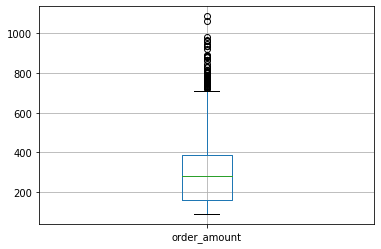

In [6]:
filtered_df = df[(df['shop_id'] != 42) & (df['shop_id'] != 78)]
filtered_df.boxplot('order_amount')

According to the documentation of `pandas.DataFrame.boxplot`, the edges of the box indeicates the 1st (Q1) and 3rd (Q3) quartile of the of the order amount while the line in the middle is the median. The whisker extend outward by no more than 1.5 * (Q3 - Q1). As shown by the dots on the top of the graph, there are some outliers above the top whiskers even after store 42 and 78 are eliminated. The following code shows you how many outliers are outside of the whiskers:

In [7]:
Q1 = filtered_df.quantile(0.25)['order_amount']
Q3 = filtered_df.quantile(0.75)['order_amount']
IQS = Q3 - Q1
filtered_outliers = filtered_df[filtered_df['order_amount'] > Q3 + 1.5 * IQS]
filtered_outliers

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
99,100,18,752,780,5,cash,2017-03-06 23:41:16
136,137,15,961,765,5,credit_card,2017-03-26 5:06:46
219,220,23,884,780,5,credit_card,2017-03-03 20:11:05
222,223,96,829,765,5,debit,2017-03-13 15:16:25
259,260,99,963,780,4,credit_card,2017-03-25 11:41:01
...,...,...,...,...,...,...,...
4905,4906,38,748,760,4,debit,2017-03-30 17:21:52
4927,4928,74,849,765,5,cash,2017-03-28 6:55:57
4952,4953,26,786,880,5,cash,2017-03-17 1:50:18
4958,4959,70,711,865,5,credit_card,2017-03-08 17:22:51


As we can see, we only have 77 outliers above the top whiskers. This is not too bad, since they are only a fraction of the 5000 orders in the dataset. However, we can also see from the bar graph that the median deviates drastically from the more expensive orders. This means that, although we have eliminated the obvious outliers, we still have a lot of high-end shoe store that charges at a price much higher than the median price.

All the evidence makes me think that a bucketed approach would be more appropriate. Namely, we divide the order amount into buckets, normalize each bucket, and sum the normalized value. Then, assuming that stores with higher order-amount also have higher profit, we can choose a small scaling factor that reward stores with the higher order-amount.

The notations go as follows:

$n$: Total number of orders

$i \in \{1, ..., n\}$: Index of the orders

$t_i$: The order amount of the $i$th order

$B$: Bucket size

$f(t_i)$: A scaling coefficient based on the order amount

$$Weighted Bucket Average = \sum_{i \in \{1, ..., n\}} f(t_i) \times \frac{t_i \mod B}{B}$$

Where $f(t_i)$ is any function that has the property:

$$\int_{0}^{\max \{t_1, ..., t_n\}}f(x)dx = 1$$

This way, $Weighted Bucket Average$ is guaranteed to have a value between 0 and 1. For this analysis, assuming that we favor the orders with larger amount, we can naively put:
$$f(t_i) = \frac{2t_i}{\max \{t_1, ..., t_n\} ^ 2}$$

In large, the $Weighted Bucket Average$ are low when the order amount is dichotomized. If we have a low value for $Weighted Bucket Average$, that means that most stores fail to fulfill their full potential compared to the stores with more revenue. 

## Q3: What is the value of the metric?
For my metric, I choose $B = 100$.

In [8]:
BUCKET_SIZE = 100
metric = 0
max_amount = df['order_amount'].max()
def scaling_func(t):
    return 2 * t / (max_amount ** 2)
for order_amount in df['order_amount']:
    metric += scaling_func(order_amount) * order_amount % BUCKET_SIZE / BUCKET_SIZE
metric

0.34579170882489824

**Answer: The value of my metric is 0.34579170882489824.**

# Part 2
## Q1: How many orders were shipped by Speedy Express in total?
**Answer: There are 54 orders shipped by Speedy Express**

```sql
SELECT COUNT(*)
FROM Orders JOIN Shippers ON Orders.ShipperID = Shippers.ShipperID 
WHERE Shippers.ShipperName = 'Speedy Express';
```

## Q2: What is the last name of the employee with the most orders?
**Answer: The last name is Peacock with 40 orders**

```sql
SELECT LastName, COUNT(OrderID) as NumOrders
FROM Orders JOIN Employees ON Orders.EmployeeID = Employees.EmployeeID
GROUP BY Employees.EmployeeID
ORDER BY NumOrders DESC
LIMIT 1;
```

## Q3: What product was ordered the most by customers in Germany?
**Answer: The product is Boston Grab Meat with 60 orders from Germany**

```sql
SELECT ProductName, SUM(Quantity) AS NumProducts
FROM Orders JOIN OrderDetails ON Orders.OrderID = OrderDetails.OrderID
JOIN Customers ON Orders.CustomerID = Customers.CustomerID
JOIN Products ON Products.ProductID = OrderDetails.ProductID
WHERE Customers.Country = 'Germany'
GROUP BY ProductName
ORDER BY NumProducts DESC
LIMIT 1;
```